In [1]:
# 必要なライブラリのインポート．
from abc import ABC, abstractmethod
import os
import glob
from collections import deque
from time import time
from datetime import timedelta
import pickle
from base64 import b64encode
import math
import numpy as np
import torch
from torch import nn
from torch.distributions import Normal
import torch.nn.functional as F
import gym
import matplotlib.pyplot as plt
from IPython.display import HTML

import robo_gym
from robo_gym.wrappers.exception_handling import ExceptionHandling

# Gymの警告を一部無視する．
gym.logger.set_level(40)
# matplotlibをColab上で描画するためのコマンド．
%matplotlib inline

In [2]:
def atanh(x):
    """ tanh の逆関数． """
    return 0.5 * (torch.log(1 + x + 1e-6) - torch.log(1 - x + 1e-6))


def evaluate_lop_pi(means, log_stds, actions):
    """ 平均(mean)，標準偏差の対数(log_stds)でパラメータ化した方策における，行動(actions)の確率密度の対数を計算する． """
    noises = (atanh(actions) - means) / (log_stds.exp() + 1e-8)
    return calculate_log_pi(log_stds, noises, actions)

In [3]:
def calculate_log_pi(log_stds, noises, actions):
    """ 確率論的な行動の確率密度を返す． """

    # NOTE: 入力はすべて (batch_size, |A|) となっているので，この関数では　batch_size　分の確率密度の対数 \log \pi(a|s) を
    # それぞれ独立に計算し (batch_size, 1) で返します．

    # ガウス分布 `N(0, stds * I)` における `noises * stds` の確率密度の対数(= \log \pi(u|a))を計算する．
    stds = log_stds.exp()
    gaussian_log_probs = Normal(torch.zeros_like(stds), stds).log_prob(stds * noises).sum(dim=-1, keepdim=True)

    # NOTE: gaussian_log_probs には (batch_size, 1) で表された確率密度の対数 \log p(u|s) が入っています．

    log_pis = gaussian_log_probs - torch.log(1 - actions**2 + 1e-6).sum(dim=-1, keepdim=True)

    return log_pis

In [4]:
def reparameterize(means, log_stds):
    """ Reparameterization Trickを用いて，確率論的な行動とその確率密度を返す． """

    # 標準偏差．
    stds = log_stds.exp()

    noises = torch.randn_like(means)
    actions = torch.tanh(means+noises*stds)

    # 確率論的な行動の確率密度の対数を計算する．
    log_pis = calculate_log_pi(log_stds, noises, actions)

    return actions, log_pis

In [5]:
def fix_state_dim(state):
    return np.concatenate([state['agent_pose'], state['occupancy_grid']])

In [6]:
class SACActor(nn.Module):

    def __init__(self, state_shape, action_shape):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(state_shape[0], 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 2 * action_shape[0]),
        )
        
        torch.nn.init.xavier_uniform_(self.net[0].weight)
        torch.nn.init.xavier_uniform_(self.net[2].weight)
        torch.nn.init.xavier_uniform_(self.net[4].weight, gain=1.0)

    def forward(self, states):
        means, log_stds = self.net(states).chunk(2, dim=-1)
        return torch.tanh(means)

    def sample(self, states):
        means, log_stds = self.net(states).chunk(2, dim=-1)
        log_stds = log_stds.clamp(-20, 2)
        return reparameterize(means, log_stds)

In [7]:
class SACCritic(nn.Module):

    def __init__(self, state_shape, action_shape):
        super().__init__()

        self.net1 = nn.Sequential(
            nn.Linear(state_shape[0] + action_shape[0], 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )
        self.net2 = nn.Sequential(
            nn.Linear(state_shape[0] + action_shape[0], 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )
        
        for i in [0,2,4]:
            torch.nn.init.xavier_uniform_(self.net1[i].weight)
            torch.nn.init.xavier_uniform_(self.net2[i].weight)

    def forward(self, states, actions):
        sa = torch.cat([states, actions], dim=-1)
        q1 = self.net1(sa)
        q2 = self.net2(sa)
        return q1, q2

In [8]:
class ReplayBuffer:

    def __init__(self, buffer_size, state_shape, action_shape, device):
        # 次にデータを挿入するインデックス．
        self._p = 0
        # データ数．
        self._n = 0
        # リプレイバッファのサイズ．
        self.buffer_size = buffer_size

        # GPU上に保存するデータ．
        self.states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)
        self.actions = torch.empty((buffer_size, *action_shape), dtype=torch.float, device=device)
        self.rewards = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.dones = torch.empty((buffer_size, 1), dtype=torch.float, device=device)
        self.next_states = torch.empty((buffer_size, *state_shape), dtype=torch.float, device=device)

    def append(self, state, action, reward, done, next_state):
        self.states[self._p].copy_(torch.from_numpy(state))
        self.actions[self._p].copy_(torch.from_numpy(action))
        self.rewards[self._p] = float(reward)
        self.dones[self._p] = float(done)
        self.next_states[self._p].copy_(torch.from_numpy(next_state))

        self._p = (self._p + 1) % self.buffer_size
        self._n = min(self._n + 1, self.buffer_size)

    def sample(self, batch_size):
        idxes = np.random.randint(low=0, high=self._n, size=batch_size)
        return (
            self.states[idxes],
            self.actions[idxes],
            self.rewards[idxes],
            self.dones[idxes],
            self.next_states[idxes]
        )

In [9]:
class Algorithm(ABC):

    def explore(self, state):
        """ 確率論的な行動と，その行動の確率密度の対数 \log(\pi(a|s)) を返す． """
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze(0)
        with torch.no_grad():
            action, log_pi = self.actor.sample(state)
        return action.cpu().numpy()[0], log_pi.item()

    def exploit(self, state):
        """ 決定論的な行動を返す． """
        state = torch.tensor(state, dtype=torch.float, device=self.device).unsqueeze(0)
        with torch.no_grad():
            action = self.actor(state)
        return action.cpu().numpy()[0]

    @abstractmethod
    def is_update(self, steps):
        """ 現在のトータルのステップ数(steps)を受け取り，アルゴリズムを学習するか否かを返す． """
        pass

    @abstractmethod
    def step(self, env, state, t, steps):
        """ 環境(env)，現在の状態(state)，現在のエピソードのステップ数(t)，今までのトータルのステップ数(steps)を
            受け取り，リプレイバッファへの保存などの処理を行い，状態・エピソードのステップ数を更新する．
        """
        pass

    @abstractmethod
    def update(self):
        """ 1回分の学習を行う． """
        pass

In [10]:
def init(module):
    nn.init.orthogonal_(module.weight.data, gain=nn.init.calculate_gain('relu'))
    nn.init.constant_(module.bias.data, 0)
    return module

class Encoder(nn.Module):
    
    def __init__(self, map_output=100, pose_output=50, map_size=128):
        super().__init__()
        self.map_size = map_size

        self.map_conv = nn.Sequential(
            # 128*128 -> 32*32
            init(nn.Conv2d(1, 16, kernel_size=8, stride=4, padding=2)),
            nn.ReLU(),
            # 32*32 -> 15*15
            init(nn.Conv2d(16, 32, kernel_size=4, stride=2)),
            nn.ReLU(),
            # 15*15 -> 13*13
            init(nn.Conv2d(32, 32, kernel_size=3, stride=1)),
            nn.ReLU(),
            nn.Flatten(),
            # 32*13*13 -> map_output
            init(nn.Linear(32*13*13, map_output)),
            nn.ReLU()
        )
        self.pose_buf = nn.Sequential(
            # 3 -> pose_output
            init(nn.Linear(3, pose_output)),
            nn.ReLU()
        )
        
    def forward(self, obs):
        map_img = obs['occupancy_grid'].reshape((self.map_size, self.map_size)).T
        map_img = torch.tensor(map_img, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        pose = torch.tensor(obs['agent_pose'], dtype=torch.float32)
        
        map_out = self.map_conv(map_img).squeeze()
        pose_out = self.pose_buf(pose).squeeze()
        return torch.cat([map_out, pose_out]).detach().numpy()

In [11]:
class Trainer:

    def __init__(self, env, env_test, algo, encoder, seed=0, num_steps=10**6, eval_interval=10**4, num_eval_episodes=3):

        self.env = env
        self.env_test = env_test
        self.algo = algo
        self.encoder = encoder

#         # 環境の乱数シードを設定する．
#         self.env.seed(seed)
#         self.env_test.seed(2**31-seed)

        # 平均収益を保存するための辞書．
        self.returns = {'step': [], 'return': []}

        # データ収集を行うステップ数．
        self.num_steps = num_steps
        # 評価の間のステップ数(インターバル)．
        self.eval_interval = eval_interval
        # 評価を行うエピソード数．
        self.num_eval_episodes = num_eval_episodes

    def train(self):
        """ num_stepsステップの間，データ収集・学習・評価を繰り返す． """

        # 学習開始の時間
        self.start_time = time()
        # エピソードのステップ数．
        t = 0

        # 環境を初期化する．
        # reset SLAM and generate new initial pose
        state = self.env.reset(new_room=False, new_agent_pose=True)
        with torch.no_grad():
            state = self.encoder(state)

        for steps in range(1, self.num_steps + 1):
            # 環境(self.env)，現在の状態(state)，現在のエピソードのステップ数(t)，今までのトータルのステップ数(steps)を
            # アルゴリズムに渡し，状態・エピソードのステップ数を更新する．
            
            state, t = self.algo.step(self.env, state, t, steps)

            # アルゴリズムが準備できていれば，1回学習を行う．
            if self.algo.is_update(steps):
                self.algo.update()

            # 一定のインターバルで評価する．
            if steps % self.eval_interval == 0:
                self.evaluate(steps)
                
    def evaluate(self, steps):
        """ 複数エピソード環境を動かし，平均収益を記録する． """

        returns = []
        state = self.env_test.reset(new_room=True, new_agent_pose=True)
        with torch.no_grad():
            state = self.encoder(state)
        
        for _ in range(self.num_eval_episodes):
            state = self.env_test.reset(new_room=False, new_agent_pose=True)
            with torch.no_grad():
                state = self.encoder(state)
            done = False
            episode_return = 0.0

            while (not done):
                action = self.algo.exploit(state)
                print(action)
                state, reward, done, _ = self.env_test.step(action)
                with torch.no_grad():
                    state = self.encoder(state)
                episode_return += reward

            returns.append(episode_return)

        mean_return = np.mean(returns)
        self.returns['step'].append(steps)
        self.returns['return'].append(mean_return)

        print(f'Num steps: {steps:<6}   '
              f'Return: {mean_return:<5.1f}   '
              f'Time: {self.time}')
        
    def plot(self):
        """ 平均収益のグラフを描画する． """
        fig = plt.figure(figsize=(8, 6))
        plt.plot(self.returns['step'], self.returns['return'])
        plt.xlabel('Steps', fontsize=24)
        plt.ylabel('Return', fontsize=24)
        plt.tick_params(labelsize=18)
        plt.title(f'{self.env.unwrapped.spec.id}', fontsize=24)
        plt.tight_layout()

    @property
    def time(self):
        """ 学習開始からの経過時間． """
        return str(timedelta(seconds=int(time() - self.start_time)))

In [12]:
class SAC(Algorithm):

    def __init__(self, state_shape, action_shape, encoder, device=torch.device('cuda'), seed=0,
                 batch_size=256, gamma=0.99, lr_actor=3e-4, lr_critic=3e-4,
                 replay_size=10**6, start_steps=10**4, tau=5e-3, alpha=0.2, reward_scale=1.0):
        super().__init__()

        # シードを設定する．
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)

        # リプレイバッファ．
        self.buffer = ReplayBuffer(
            buffer_size=replay_size,
            state_shape=state_shape,
            action_shape=action_shape,
            device=device,
        )
        
        self.encoder = encoder

        # Actor-Criticのネットワークを構築する．
        self.actor = SACActor(
            state_shape=state_shape,
            action_shape=action_shape
        ).to(device)
        self.critic = SACCritic(
            state_shape=state_shape,
            action_shape=action_shape
        ).to(device)
        self.critic_target = SACCritic(
            state_shape=state_shape,
            action_shape=action_shape
        ).to(device).eval()

        # ターゲットネットワークの重みを初期化し，勾配計算を無効にする．
        self.critic_target.load_state_dict(self.critic.state_dict())
        for param in self.critic_target.parameters():
            param.requires_grad = False

        # オプティマイザ．
        self.optim_actor = torch.optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optim_critic = torch.optim.Adam(self.critic.parameters(), lr=lr_critic)

        # その他パラメータ．
        self.learning_steps = 0
        self.batch_size = batch_size
        self.device = device
        self.gamma = gamma
        self.start_steps = start_steps
        self.tau = tau
        self.alpha = alpha
        self.reward_scale = reward_scale

    def is_update(self, steps):
        # 学習初期の一定期間(start_steps)は学習しない．
        return steps >= max(self.start_steps, self.batch_size)

    def step(self, env, state, t, steps):
        t += 1

        # 学習初期の一定期間(start_steps)は，ランダムに行動して多様なデータの収集を促進する．
        if steps <= self.start_steps:
            action = env.action_space.sample()
        else:
            action, _ = self.explore(state)
        next_state, reward, done, _ = env.step(action)
        with torch.no_grad():
            next_state = self.encoder(next_state)
        
        
        # not ignore done

        # リプレイバッファにデータを追加する．
        self.buffer.append(state, action, reward, done, next_state)

        # エピソードが終了した場合には，環境をリセットする．
        if done:
            t = 0
            next_state = env.reset()
            with torch.no_grad():
                next_state = self.encoder(next_state)

        return next_state, t

    def update(self):
        self.learning_steps += 1
        states, actions, rewards, dones, next_states = self.buffer.sample(self.batch_size)

        self.update_critic(states, actions, rewards, dones, next_states)
        self.update_actor(states)
        self.update_target()

    def update_critic(self, states, actions, rewards, dones, next_states):
        # 現在のソフト状態行動価値を計算する．
        curr_qs1, curr_qs2 = self.critic(states, actions)

        with torch.no_grad():
            # ソフト状態価値のターゲットを計算します．
            # target_vs = ...
            next_actions, log_pis = self.actor.sample(next_states)
            qs1, qs2 = self.critic_target(next_states, next_actions)
            target_vs = torch.min(qs1, qs2) - self.alpha * log_pis

        # ソフト状態行動価値のターゲットを計算します．
        # target_qs = ...
        target_qs = rewards * self.reward_scale + (1 - dones) * self.gamma * target_vs

        loss_critic1 = (curr_qs1 - target_qs).pow_(2).mean()
        loss_critic2 = (curr_qs2 - target_qs).pow_(2).mean()

        self.optim_critic.zero_grad()
        (loss_critic1 + loss_critic2).backward(retain_graph=False)
        self.optim_critic.step()

    def update_actor(self, states):
        actions, log_pis = self.actor.sample(states)
        qs1, qs2 = self.critic(states, actions)
        loss_actor = (self.alpha * log_pis - torch.min(qs1, qs2)).mean()

        self.optim_actor.zero_grad()
        loss_actor.backward(retain_graph=False)
        self.optim_actor.step()

    def update_target(self):
        for t, s in zip(self.critic_target.parameters(), self.critic.parameters()):
            t.data.mul_(1.0 - self.tau)
            t.data.add_(self.tau * s.data)

In [13]:
ENV_ID = 'CubeRoomSearchLikeContinuously-v0'
target_machine_ip = 'localhost'
SEED = 0
REWARD_SCALE = 1.0
NUM_STEPS = 5 * 10 ** 4
# EVAL_INTERVAL = 10 ** 3
EVAL_INTERVAL = 60

map_enc = 100
pose_enc = 50

env = gym.make(ENV_ID, ip=target_machine_ip, gui=True, max_episode_steps=20)
env_test = gym.make(ENV_ID, ip=target_machine_ip, gui=False, max_episode_steps=20)

encoder = Encoder(map_enc, pose_enc, env.map_size)

# s_shape = (env.observation_space['agent_pose'].low.size + env.observation_space['occupancy_grid'].low.size, )
state_shape = (map_enc+pose_enc,)

algo = SAC(
    state_shape=state_shape,
    action_shape=env.action_space.shape,
    seed=SEED,
    replay_size=10**6,
    reward_scale=REWARD_SCALE,
    encoder=encoder,
)

trainer = Trainer(
    env=env,
    env_test=env_test,
    algo=algo,
    seed=SEED,
    num_steps=NUM_STEPS,
    eval_interval=EVAL_INTERVAL,
    encoder=encoder,
)

Starting new Robot Server | Tentative 1
<class 'server_manager_pb2.RobotServer'>
True 
Successfully started Robot Server at localhost:58379
Starting new Robot Server | Tentative 1
<class 'server_manager_pb2.RobotServer'>
True 
Successfully started Robot Server at localhost:56483


In [14]:
trainer.train()

[0.9772602  0.7525     0.96384543]
[0.98302734 0.7477695  0.9580984 ]
[0.9832126  0.7487733  0.95780134]
[0.98333716 0.74954444 0.9576123 ]
[0.98337007 0.7496624  0.95762545]
[0.98340267 0.74977773 0.95763874]
[0.9834097  0.74991786 0.9576612 ]
[0.9834152  0.7501086  0.95767426]
[0.98342425 0.75021887 0.95767   ]
[0.9834327  0.75031954 0.95766634]
[0.9834396  0.7504052  0.95766044]
[0.9834462  0.75048816 0.9576518 ]
[0.9834515  0.75055605 0.9576445 ]
[0.9834565 0.750625  0.9576371]
[0.98345953 0.7506625  0.9576329 ]
[0.98346204 0.7506906  0.9576299 ]
[0.9834641  0.75071573 0.957627  ]
[0.9834665  0.75074327 0.957624  ]
[0.98346883 0.75076663 0.95762134]
[0.983471  0.7507861 0.9576189]
[0.9834734  0.7507922  0.95761585]
[0.98347586 0.75080013 0.95761275]
[0.9834782  0.750808   0.95760983]
[0.9834805  0.75081515 0.9576069 ]
[0.9834824 0.7508291 0.9576039]
[0.98348397 0.750858   0.9576001 ]
[0.9834855  0.75088125 0.9575968 ]
[0.98348683 0.7509024  0.9575939 ]
[0.9834875  0.75091344 0.9575

[0.99938464 0.9966302  0.9944569 ]
[0.99938464 0.9966302  0.9944569 ]
[0.99938464 0.9966302  0.9944569 ]
[0.99938464 0.9966302  0.9944569 ]
[0.99938464 0.9966302  0.9944569 ]
[0.99938464 0.9966302  0.9944569 ]
[0.99938464 0.9966302  0.9944569 ]
[0.99938464 0.9966302  0.9944569 ]
[0.99938464 0.9966302  0.9944569 ]
[0.99938464 0.9966302  0.9944569 ]
[0.99938464 0.9966302  0.9944569 ]
[ 0.4745525 -0.5100454  0.8836396]
[ 0.46094027 -0.5090894   0.88610506]
[ 0.46339712 -0.5106487   0.88560116]
[ 0.46584946 -0.51032114  0.8850644 ]
[ 0.46691543 -0.5103209   0.8848248 ]
[ 0.4674377 -0.5103766  0.8847036]
[ 0.467584  -0.510533   0.8846581]
[ 0.4676893  -0.5106749   0.88462394]
[ 0.46673283 -0.51116323  0.88478124]
[ 0.46614563 -0.511535    0.8848717 ]
[ 0.46609786 -0.5117401   0.88486403]
[ 0.46443975 -0.51243335  0.88514906]
[ 0.78596175 -0.12200919  0.9626365 ]
[ 0.78578115 -0.12292124  0.96272206]
[ 0.7855735  -0.12411669  0.9628302 ]
[ 0.785487   -0.12413343  0.9628423 ]
[ 0.78565496 -0.

[ 0.7856388  -0.11864525  0.9624738 ]
[ 0.7856374  -0.11864965  0.9624743 ]
[ 0.78563666 -0.11865007  0.96247447]
[ 0.7856345  -0.11865859  0.9624753 ]
[ 0.78562343 -0.11871038  0.96247977]
[ 0.78562313 -0.11871076  0.96247977]
[ 0.7856305  -0.11867936  0.96247697]
[ 0.78563166 -0.11867363  0.9624765 ]
[ 0.7856323  -0.11867018  0.9624762 ]
[ 0.78563243 -0.1186698   0.96247613]
[ 0.78563255 -0.11866708  0.962476  ]
[ 0.7856329  -0.11866522  0.96247584]
[ 0.7856332  -0.11866309  0.9624757 ]
[ 0.7856338 -0.1186605  0.9624756]
[ 0.7856338  -0.11865886  0.9624755 ]
[ 0.7856342  -0.11865559  0.96247524]
[ 0.78563434 -0.11865408  0.9624752 ]
[ 0.7856347  -0.11865151  0.96247506]
[ 0.78563493 -0.11864998  0.96247494]
[ 0.7856351  -0.11864773  0.96247476]
[ 0.78563553 -0.1186453   0.9624746 ]
[ 0.7856357  -0.11864325  0.9624745 ]
[ 0.7856362  -0.1186404   0.96247435]
[ 0.78563625 -0.11863899  0.9624742 ]
[ 0.7856364  -0.11863738  0.96247417]
[ 0.78563666 -0.11863437  0.9624739 ]
[ 0.78563714 -0

[0.72408473 0.90803576 0.98366964]
[0.72409916 0.9080319  0.98366946]
[0.7241283 0.9080239 0.983669 ]
[0.7241268  0.90802413 0.983669  ]
[0.72413415 0.90802205 0.98366886]
[0.72415376 0.90801656 0.98366857]
[0.7241546  0.9080162  0.98366857]
[0.7241753  0.90801054 0.98366827]
[0.72419745 0.9080045  0.9836679 ]
[0.72420394 0.9080027  0.9836678 ]
[0.72421265 0.9080002  0.9836677 ]
[0.72420454 0.9080021  0.9836678 ]
[0.7242135  0.90799975 0.9836677 ]
[0.724231  0.9079947 0.9836674]
[0.7242469  0.9079903  0.98366714]
[0.7242695  0.90798414 0.9836668 ]
[0.7242751 0.9079824 0.9836667]
[0.72429454 0.9079772  0.9836664 ]
[0.7242867  0.9079789  0.98366654]
[0.7242987  0.9079756  0.98366636]
[0.7243135  0.90797156 0.9836661 ]
[0.7243209 0.9079693 0.983666 ]
[0.72433794 0.90796477 0.9836657 ]
[0.72434676 0.9079622  0.9836656 ]
[0.72436285 0.9079577  0.98366535]
[0.72438705 0.90795124 0.98366493]
[0.7243991  0.9079477  0.98366475]
[0.724412  0.9079442 0.9836646]
[0.7244171  0.90794253 0.98366445]


[ 0.7254826  -0.27399668  0.95208   ]
[ 0.7254743  -0.27423078  0.95209   ]
[ 0.7254733  -0.27426463  0.95209146]
[ 0.7254771  -0.27414453  0.9520863 ]
[ 0.72547656 -0.2741641   0.95208716]
[ 0.725471   -0.2743267   0.95209414]
[ 0.72547364 -0.27424797  0.95209074]
[ 0.7254754  -0.27418652  0.9520881 ]
[ 0.7254716  -0.27430218  0.95209306]
[ 0.72546744 -0.27442163  0.95209825]
[ 0.7254646  -0.2745096   0.95210195]
[ 0.72546756 -0.27442     0.95209813]
[ 0.72546446 -0.27450624  0.9521018 ]
[ 0.7254635 -0.2745406  0.9521034]
[ 0.7254574  -0.27472144  0.9521111 ]
[ 0.7254554  -0.27477223  0.9521133 ]
[ 0.72545743 -0.27470744  0.95211047]
[ 0.7254626  -0.27455544  0.952104  ]
[ 0.7254629  -0.27455026  0.9521038 ]
[ 0.72546124 -0.27459016  0.95210546]
[ 0.7254491  -0.27495864  0.9521213 ]
[ 0.7254567  -0.27473116  0.95211154]
[ 0.725458  -0.2746829  0.9521094]
[ 0.7254589 -0.2746503  0.9521081]
[ 0.7254593  -0.27463418  0.95210737]
[ 0.7254524  -0.27484813  0.95211655]
[ 0.7254536  -0.27481

[0.9123446  0.02674236 0.9935722 ]
[0.91234535 0.02673784 0.9935722 ]
[0.9123461  0.02673227 0.9935722 ]
[0.91234714 0.02672658 0.9935722 ]
[0.91234726 0.02672729 0.9935722 ]
[0.912343   0.0267418  0.99357206]
[0.91234183 0.02674909 0.99357206]
[0.91234124 0.02675573 0.99357206]
[0.9123404  0.02676312 0.99357206]
[0.9123404  0.02676741 0.9935721 ]
[0.91233975 0.02677405 0.9935721 ]
[0.912339   0.02677661 0.99357206]
[0.9123394  0.02677459 0.99357206]
[0.9123396  0.0267719  0.99357206]
[0.9123401  0.02676887 0.99357206]
[0.9123407  0.02676541 0.9935721 ]
[0.91234124 0.02676199 0.9935721 ]
[0.9123419  0.02675776 0.9935721 ]
[0.9123426  0.02675359 0.9935721 ]
[0.91234344 0.02674796 0.9935721 ]
[0.9123445  0.02674197 0.9935722 ]
[0.9123455  0.02673554 0.9935722 ]
[0.9123467  0.02672824 0.9935722 ]
[0.9123478  0.02672414 0.99357224]
[0.91234416 0.02673658 0.9935721 ]
[0.912344   0.02674004 0.9935721 ]
[0.91234416 0.02674281 0.9935721 ]
[0.91234344 0.02674936 0.9935721 ]
[0.9123426  0.026753

[ 0.93740785 -0.22368191  0.9939174 ]
[ 0.9374124  -0.22371271  0.99391747]
[ 0.93741006 -0.22369756  0.9939174 ]
[ 0.9374099  -0.22369646  0.9939174 ]
[ 0.93741286 -0.22371791  0.99391747]
[ 0.93741417 -0.22372766  0.99391747]
[ 0.9374116  -0.22371115  0.99391747]
[ 0.93741435 -0.22373037  0.99391747]
[ 0.93741506 -0.2237359   0.99391747]
[ 0.93741447 -0.22373326  0.99391747]
[ 0.93741643 -0.22374669  0.9939175 ]
[ 0.937413   -0.22372364  0.99391747]
[ 0.93741834 -0.22376081  0.9939175 ]
[ 0.9374156  -0.22374332  0.99391747]
[ 0.93741655 -0.22375119  0.9939175 ]
[ 0.93741655 -0.22375104  0.9939175 ]
[ 0.9374194  -0.22377148  0.9939175 ]
[ 0.93742037 -0.22377875  0.9939175 ]
[ 0.9374201 -0.2237779  0.9939175]
[ 0.9374195 -0.2237739  0.9939175]
[ 0.93742067 -0.22378258  0.9939175 ]
[ 0.93741953 -0.22377639  0.9939175 ]
[ 0.93742174 -0.22379263  0.9939176 ]
[ 0.9374241  -0.22380914  0.9939176 ]
[ 0.9374252  -0.22381763  0.9939176 ]
[ 0.9374247 -0.2238149  0.9939176]
[ 0.93742573 -0.22382

[ 0.91303617 -0.03116612  0.9933436 ]
[ 0.9130909  -0.03173198  0.99334544]
[ 0.9130812  -0.03166863  0.993345  ]
[ 0.9131522  -0.03237607  0.9933475 ]
[ 0.913189   -0.03274921  0.99334884]
[ 0.9132151  -0.0330194   0.99334973]
[ 0.91324353 -0.03331168  0.99335074]
[ 0.9132763  -0.03365224  0.9933519 ]
[ 0.9133148  -0.03405042  0.9933532 ]
[ 0.91335344 -0.03445004  0.99335456]
[ 0.9134029  -0.03496116  0.9933562 ]
[ 0.91345817 -0.03553275  0.9933582 ]
[ 0.91351914 -0.03616261  0.9933603 ]
[ 0.9135866  -0.03685757  0.99336267]
[ 0.913661   -0.03759195  0.99336475]
[ 0.91374743 -0.03843021  0.9933671 ]
[ 0.9138183  -0.03911704  0.993369  ]
[ 0.91393006 -0.04020166  0.993372  ]
[ 0.914037   -0.04123715  0.9933749 ]
[ 0.9141515  -0.04234621  0.993378  ]
[ 0.9143335  -0.04410977  0.9933829 ]
[ 0.91455525 -0.04625897  0.9933889 ]
[ 0.91472113 -0.04785299  0.9933941 ]
[ 0.91477066 -0.04832941  0.9933956 ]
[ 0.914832   -0.04891801  0.99339753]
[ 0.9149047  -0.04961643  0.9933998 ]
[ 0.91498095

[ 0.935694   -0.210728    0.99388707]
[ 0.9356498  -0.21039261  0.99388593]
[ 0.9356096  -0.21008876  0.9938849 ]
[ 0.9355582  -0.20969845  0.99388367]
[ 0.93549776 -0.20924032  0.9938821 ]
[ 0.93543243 -0.20874494  0.9938805 ]
[ 0.9353477  -0.20810461  0.99387836]
[ 0.93533075 -0.20797573  0.993878  ]
[ 0.9353342  -0.20800114  0.99387807]
[ 0.93533695 -0.20802067  0.9938781 ]
[ 0.9353412  -0.20805167  0.99387825]
[ 0.9353389  -0.20803566  0.9938782 ]
[ 0.93534136 -0.20805243  0.99387825]
[ 0.935342   -0.20805717  0.99387825]
[ 0.93533903 -0.20803581  0.9938782 ]
[ 0.9353432  -0.20806606  0.9938783 ]
[ 0.93534124 -0.20805205  0.99387825]
[ 0.9353425 -0.2080613  0.9938783]
[ 0.9353441  -0.20807293  0.9938783 ]
[ 0.93534243 -0.2080606   0.99387825]
[ 0.9353441  -0.20807287  0.9938783 ]
[ 0.9353429  -0.20806454  0.9938783 ]
[ 0.935346   -0.20808648  0.99387836]
[ 0.9353438 -0.2080709  0.9938783]
[ 0.93534327 -0.20806666  0.9938783 ]
[ 0.9353432 -0.2080665  0.9938783]
[ 0.93534476 -0.20807

[ 0.91033965 -0.00375753  0.99323344]
[ 0.9103601  -0.00381785  0.9932292 ]
[ 0.91035044 -0.00378974  0.9932312 ]
[ 0.91034025 -0.00375887  0.9932333 ]
[ 0.9103415  -0.00376289  0.993233  ]
[ 0.91034096 -0.00376107  0.99323314]
[ 0.91033256 -0.00373643  0.99323493]
[ 0.91033363 -0.00373938  0.99323463]
[ 0.91032314 -0.00370871  0.99323684]
[ 0.9103112  -0.00367298  0.9932393 ]
[ 0.9103251  -0.00371416  0.9932365 ]
[ 0.91032374 -0.00370984  0.9932367 ]
[ 0.9103008  -0.00364204  0.9932415 ]
[ 0.9103002  -0.00364049  0.9932416 ]
[ 0.9103074  -0.00366156  0.9932401 ]
[ 0.9103044  -0.00365286  0.9932408 ]
[ 0.91030544 -0.00365635  0.99324054]
[ 0.9103013  -0.00364377  0.99324137]
[ 0.91029364 -0.00362097  0.993243  ]
[ 0.91028845 -0.00360577  0.99324405]
[ 0.9102937  -0.00362136  0.993243  ]
[ 0.910271   -0.00355425  0.9932477 ]
[ 0.91026545 -0.0035386   0.9932487 ]
[ 0.9102659  -0.00353979  0.9932486 ]
[ 0.910266   -0.00354015  0.9932486 ]
[ 0.91028106 -0.00358372  0.9932456 ]
[ 0.91027445

[ 0.91172403 -0.01781145  0.9932999 ]
[ 0.9117431 -0.0179995  0.9933006]
[ 0.9117623  -0.01818874  0.9933013 ]
[ 0.91174304 -0.01799986  0.9933006 ]
[ 0.91176856 -0.01825122  0.9933015 ]
[ 0.9117683  -0.01824892  0.9933015 ]
[ 0.9117684  -0.01824937  0.9933015 ]
[ 0.91175544 -0.01812156  0.99330103]
[ 0.91177464 -0.01831062  0.9933017 ]
[ 0.9117492 -0.0180598  0.9933008]
[ 0.91177446 -0.01830928  0.9933017 ]
[ 0.9118061  -0.01862168  0.9933028 ]
[ 0.9117993  -0.01855435  0.9933026 ]
[ 0.91179955 -0.01855599  0.9933026 ]
[ 0.91180557 -0.01861561  0.9933028 ]
[ 0.9118244  -0.01880297  0.9933035 ]
[ 0.91183674 -0.01892425  0.9933039 ]
Num steps: 3000     Return: -12.5   Time: 2:54:50
[ 0.9393186  -0.23843029  0.99395216]
[ 0.9168898  -0.06661609  0.99342906]
[ 0.917518   -0.07233588  0.9934376 ]
[ 0.9189442  -0.08624829  0.9934601 ]
[ 0.92171276 -0.11299919  0.99351835]
[ 0.92126364 -0.1086695   0.9935086 ]
[ 0.9171281  -0.06846359  0.9934325 ]
[ 0.91515636 -0.05048028  0.99340624]
[ 0.91

[ 0.9329059  -0.19119355  0.9938169 ]
[ 0.93290967 -0.19122037  0.99381703]
[ 0.9329125  -0.19124067  0.9938171 ]
[ 0.93290883 -0.1912146   0.993817  ]
[ 0.93291163 -0.1912349   0.99381703]
[ 0.93290895 -0.19121535  0.993817  ]
[ 0.9329136  -0.19124874  0.9938171 ]
[ 0.9329109  -0.1912291   0.99381703]
[ 0.9329092  -0.19121696  0.993817  ]
[ 0.932911   -0.19122979  0.99381703]
[ 0.9329063  -0.19119735  0.9938169 ]
[ 0.9329101  -0.19122341  0.99381703]
[ 0.93290913 -0.19121727  0.993817  ]
[ 0.93291223 -0.19123861  0.99381703]
[ 0.93291485 -0.19125824  0.9938171 ]
[ 0.9329102  -0.19122545  0.99381703]
[ 0.9329086 -0.1912142  0.993817 ]
[ 0.93291116 -0.19123203  0.99381703]
[ 0.93290937 -0.19121972  0.993817  ]
[ 0.93290585 -0.19119467  0.9938169 ]
[ 0.93291414 -0.19125356  0.9938171 ]
[ 0.93290985 -0.19122261  0.993817  ]
[ 0.9329079  -0.19120863  0.993817  ]
[ 0.9329106  -0.19122902  0.99381703]
[ 0.93290883 -0.19121656  0.993817  ]
[ 0.9329089  -0.19121704  0.993817  ]
[ 0.9329145  -0

[ 0.9233317  -0.12670118  0.9935593 ]
[ 0.9233327  -0.12670699  0.99355936]
[ 0.923333   -0.12670971  0.99355936]
[ 0.92333305 -0.1267105   0.99355936]
[ 0.9233357  -0.12672828  0.9935594 ]
[ 0.9233357 -0.1267286  0.9935594]
[ 0.923337   -0.12673762  0.9935595 ]
[ 0.92333263 -0.1267076   0.99355936]
[ 0.92333394 -0.12671678  0.99355936]
[ 0.9233309  -0.12669596  0.9935593 ]
[ 0.92332876 -0.12668127  0.99355924]
[ 0.92332876 -0.12668142  0.99355924]
[ 0.92332435 -0.12665182  0.99355906]
[ 0.92332476 -0.12665509  0.9935591 ]
[ 0.9233235  -0.12664658  0.99355906]
[ 0.9233279 -0.126676   0.9935592]
[ 0.9233262  -0.12666388  0.9935591 ]
[ 0.923328   -0.12667637  0.9935592 ]
[ 0.923327  -0.1266708  0.9935592]
[ 0.92331797 -0.1266084   0.9935589 ]
[ 0.9233232  -0.12664412  0.99355906]
[ 0.92332405 -0.12665018  0.99355906]
[ 0.92332494 -0.12665619  0.9935591 ]
[ 0.92332196 -0.12663597  0.993559  ]
[ 0.9233215  -0.12663256  0.993559  ]
[ 0.92332405 -0.12665069  0.99355906]
[ 0.92332065 -0.12662

[ 0.92274135 -0.12268058  0.9935414 ]
[ 0.92273426 -0.12263247  0.9935412 ]
[ 0.9227489  -0.12273175  0.99354166]
[ 0.9227425  -0.12268671  0.9935414 ]
[ 0.9227433  -0.12269308  0.9935415 ]
[ 0.92273533 -0.12263919  0.99354124]
[ 0.9227376  -0.12265484  0.9935413 ]
[ 0.9227352  -0.1226389   0.99354124]
[ 0.92272973 -0.12260129  0.99354106]
[ 0.9227272  -0.12258489  0.993541  ]
[ 0.9227339  -0.12263095  0.9935412 ]
[ 0.9227326  -0.12262143  0.9935411 ]
[ 0.9227319  -0.12261691  0.9935411 ]
[ 0.92272127 -0.12254473  0.99354076]
[ 0.9227392  -0.12266608  0.99354136]
[ 0.922725   -0.12257109  0.9935409 ]
[ 0.9227314  -0.12261368  0.9935411 ]
[ 0.92273295 -0.12262399  0.9935412 ]
[ 0.9227174  -0.12252007  0.9935407 ]
[ 0.92271775 -0.12252148  0.9935407 ]
[ 0.9227212  -0.12254538  0.9935408 ]
[ 0.92273325 -0.1226271   0.9935412 ]
[ 0.9227196  -0.1225351   0.99354076]
[ 0.9227165  -0.12251464  0.99354064]
[ 0.9227098  -0.12246893  0.99354047]
[ 0.92272115 -0.12254491  0.9935408 ]
[ 0.9227247 

[ 0.9369563  -0.22309881  0.9939125 ]
[ 0.93695694 -0.22310394  0.9939125 ]
[ 0.9369592  -0.22311835  0.9939125 ]
[ 0.9369586  -0.22311501  0.9939125 ]
[ 0.93695647 -0.22310042  0.9939125 ]
[ 0.9369551  -0.22309013  0.99391246]
[ 0.93695605 -0.22309633  0.9939125 ]
[ 0.936957   -0.22310372  0.9939125 ]
[ 0.93695426 -0.22308478  0.99391246]
[ 0.9369565  -0.22309963  0.9939125 ]
[ 0.936954   -0.2230835   0.99391246]
[ 0.93695176 -0.22306778  0.99391246]
[ 0.9369556  -0.22309369  0.9939125 ]
[ 0.93695307 -0.22307616  0.99391246]
[ 0.9369518  -0.2230678   0.99391246]
[ 0.93695194 -0.22306849  0.99391246]
[ 0.9369506  -0.22305973  0.99391246]
[ 0.93695015 -0.22305614  0.9939124 ]
[ 0.93695277 -0.22307372  0.99391246]
[ 0.9369519  -0.22306772  0.99391246]
[ 0.9369516  -0.22306545  0.99391246]
[ 0.9369515  -0.22306494  0.99391246]
[ 0.9369487  -0.22304668  0.9939124 ]
[ 0.936952   -0.22306806  0.99391246]
[ 0.936948   -0.22304095  0.9939124 ]
[ 0.93694854 -0.2230443   0.9939124 ]
[ 0.93694866

[ 0.9183635  -0.07903876  0.9934498 ]
[ 0.9185388  -0.08090498  0.9934531 ]
[ 0.9187638  -0.08330495  0.9934573 ]
[ 0.9190632  -0.08650501  0.993463  ]
[ 0.9193149  -0.08919934  0.99346775]
[ 0.9194709  -0.0908731   0.99347067]
[ 0.91965735 -0.09287699  0.99347425]
[ 0.9198917  -0.09507916  0.99347925]
[ 0.92011636 -0.09717655  0.9934841 ]
[ 0.9204457  -0.1002611   0.99349123]
[ 0.92081666 -0.10374578  0.9934993 ]
[ 0.9212323 -0.1076667  0.9935083]
[ 0.9217261  -0.11234306  0.99351907]
[ 0.92252225 -0.1199304   0.99353653]
[ 0.9233558  -0.1257935   0.99356127]
[ 0.9245446  -0.13397017  0.9935976 ]
[ 0.92586094 -0.14314641  0.9936383 ]
[ 0.9269112  -0.15041623  0.9936681 ]
[ 0.9273673  -0.15355547  0.99368036]
[ 0.9276087 -0.1552257  0.9936869]
[ 0.9277519  -0.15621993  0.9936908 ]
[ 0.92787325 -0.15706386  0.99369407]
[ 0.9280517  -0.15826169  0.9936981 ]
[ 0.92829007 -0.15986642  0.99370354]
[ 0.9284826  -0.16117768  0.99370813]
[ 0.9286128  -0.16206616  0.99371123]
[ 0.928774   -0.16

[ 0.91572803 -0.05435309  0.99341464]
[ 0.9157288  -0.05436013  0.99341464]
[ 0.91572773 -0.05435089  0.99341464]
[ 0.91572607 -0.05433597  0.9934146 ]
[ 0.9157267  -0.05434117  0.9934146 ]
[ 0.9157238  -0.05431583  0.9934146 ]
[ 0.91571647 -0.05424963  0.99341446]
[ 0.9157159  -0.05424517  0.99341446]
[ 0.91571647 -0.05425007  0.99341446]
[ 0.9157191  -0.05427358  0.9934145 ]
[ 0.9157231  -0.05430953  0.9934146 ]
[ 0.91572505 -0.05432585  0.9934146 ]
[ 0.9157269  -0.05434284  0.9934146 ]
[ 0.9157196  -0.05427732  0.9934145 ]
[ 0.91572124 -0.0542925   0.9934145 ]
[ 0.9157211  -0.05429149  0.9934145 ]
[ 0.91572076 -0.05428933  0.9934145 ]
[ 0.91571975 -0.05427928  0.9934145 ]
[ 0.9157157  -0.05424351  0.99341446]
[ 0.9157163  -0.05424865  0.99341446]
[ 0.9157185  -0.05426894  0.9934145 ]
[ 0.9157194  -0.05427551  0.9934145 ]
[ 0.9157235  -0.05431259  0.9934146 ]
[ 0.915723   -0.05430944  0.9934146 ]
[ 0.91572237 -0.05430308  0.9934146 ]
[ 0.91572106 -0.05429132  0.9934145 ]
[ 0.915722  

[ 0.9163757  -0.06013556  0.9934234 ]
[ 0.9163759 -0.0601385  0.9934234]
Num steps: 5000     Return: -12.5   Time: 4:49:01


KeyboardInterrupt: 

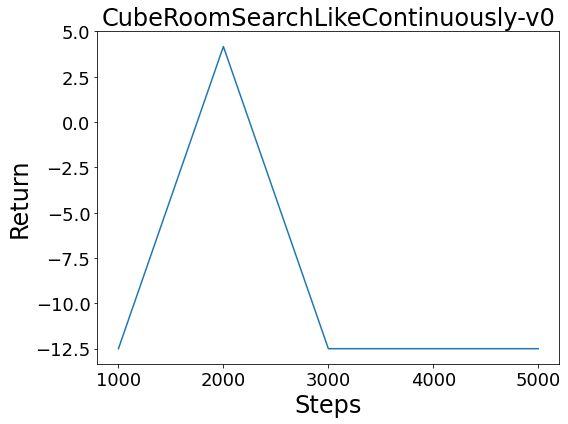

In [15]:
trainer.plot()

## Debug Zone